# Classification of Pet's Real-Life Images

Now it's time to deal with more challenging task - classification of the original [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Let's start by loading and visualizing the dataset.

In [ ]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
!tar xfz oxpets_images.tar.gz
!rm oxpets_images.tar.gz

We will define generic function to display a series of images from a list:

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

You can see that all images are located in one directory called `images`, and their name contains the name of the class (breed):

In [ ]:
fnames = os.listdir('images')[:5]
display_images([Image.open(os.path.join('images',x)) for x in fnames],titles=fnames,fontsize=30)

To simplify classification and use the same approach to loading images as in the previous part, let's sort all images into corresponding directories:

In [ ]:
for fn in os.listdir('images'):
    cls = fn[:fn.rfind('_')].lower()
    os.makedirs(os.path.join('images',cls),exist_ok=True)
    os.replace(os.path.join('images',fn),os.path.join('images',cls,fn))

Let's also define the number of classes in our dataset:

In [2]:
num_classes = len(os.listdir('images'))
num_classes

37

## Preparing dataset for Deep Learning

To start training our neural network, we need to convert all images to tensors, and also create tensors corresponding to labels (class numbers). Most neural network frameworks contain simple tools for dealing with images:
* In Tensorflow, use `tf.keras.preprocessing.image_dataset_from_directory`
* In PyTorch, use `torchvision.datasets.ImageFolder`

As you have seen from the pictures above, all of them are close to square image ratio, so we need to resize all images to square size. Also, we can organize images in minibatches.

In [3]:
import torch
import torchvision
import torchvision.transforms as tr

image_size = 224
batch_size = 32

dataset = torchvision.datasets.ImageFolder(
    'images',
    transform = tr.Compose([
        tr.Resize(image_size),
        tr.CenterCrop(image_size),
        tr.ToTensor()
    ]))

classnames = dataset.classes

Now we need to separate dataset into train and test portions:

In [4]:
n = len(dataset)
n_train = int(0.8*n)

train_data,test_data = torch.utils.data.random_split(dataset,[n_train,n-n_train])

Now define data loaders:

In [5]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)

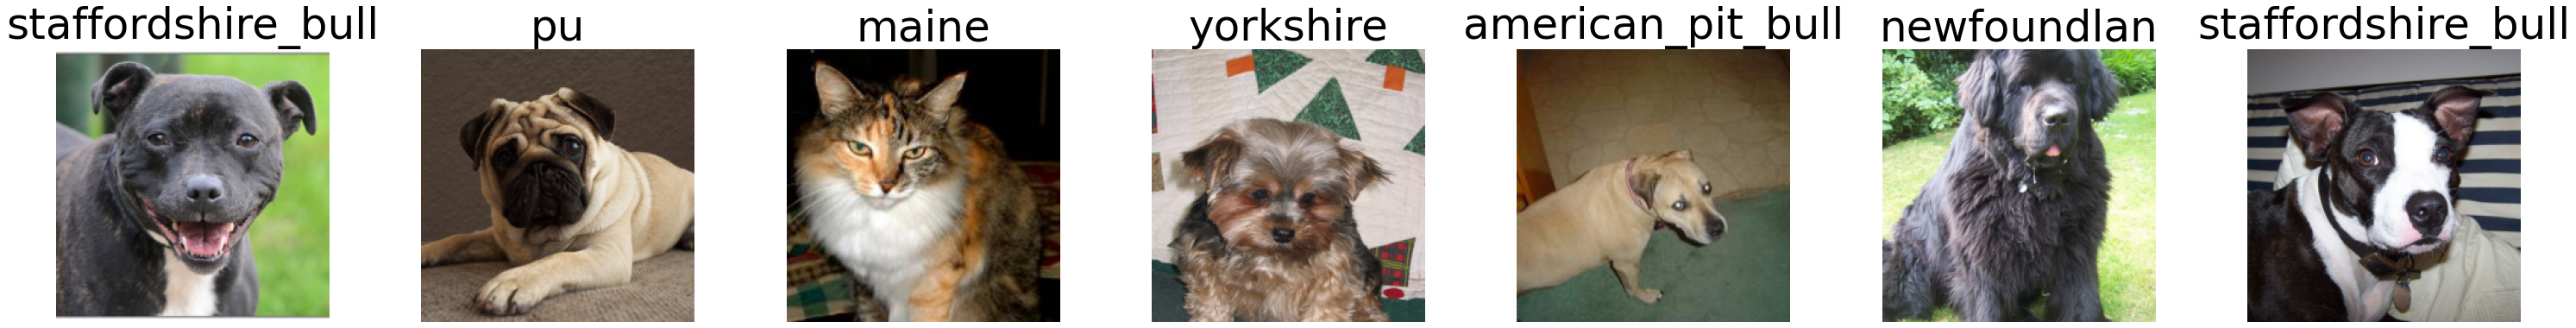

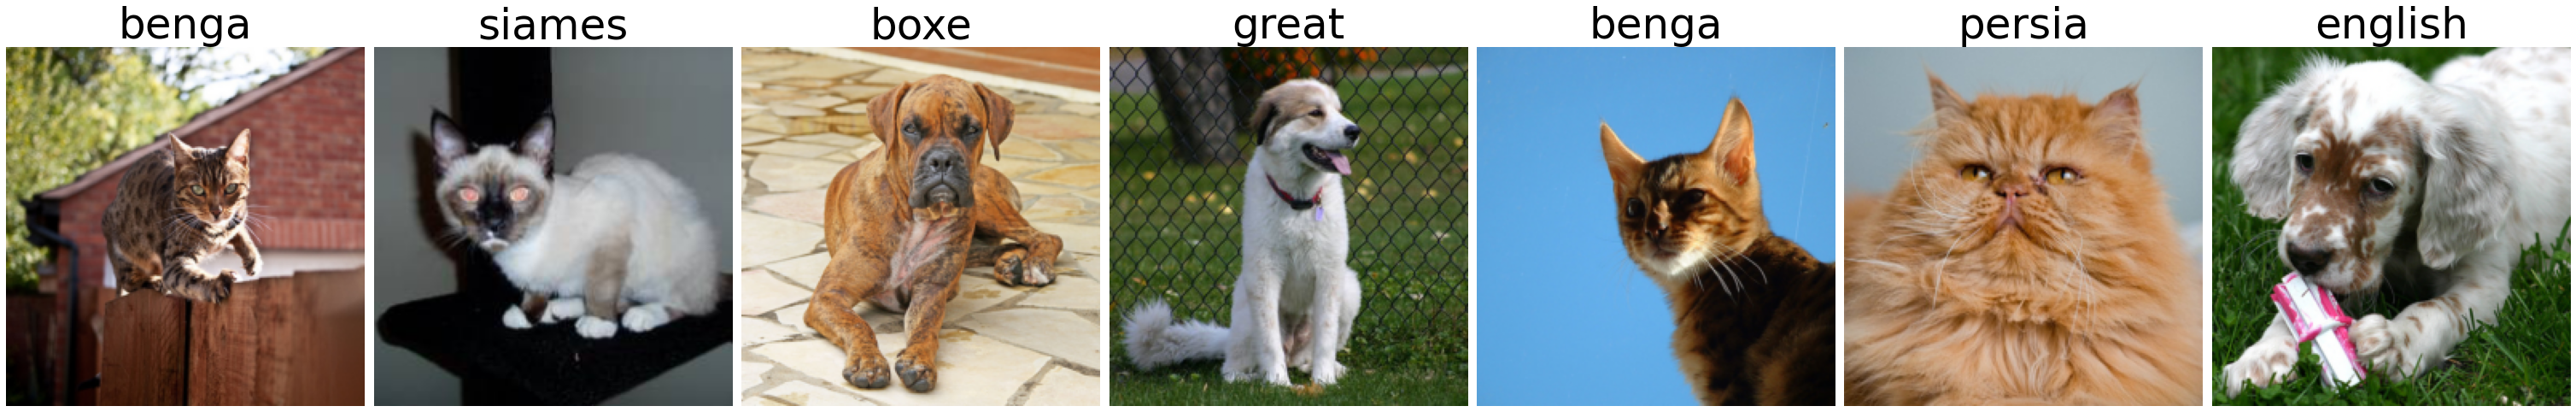

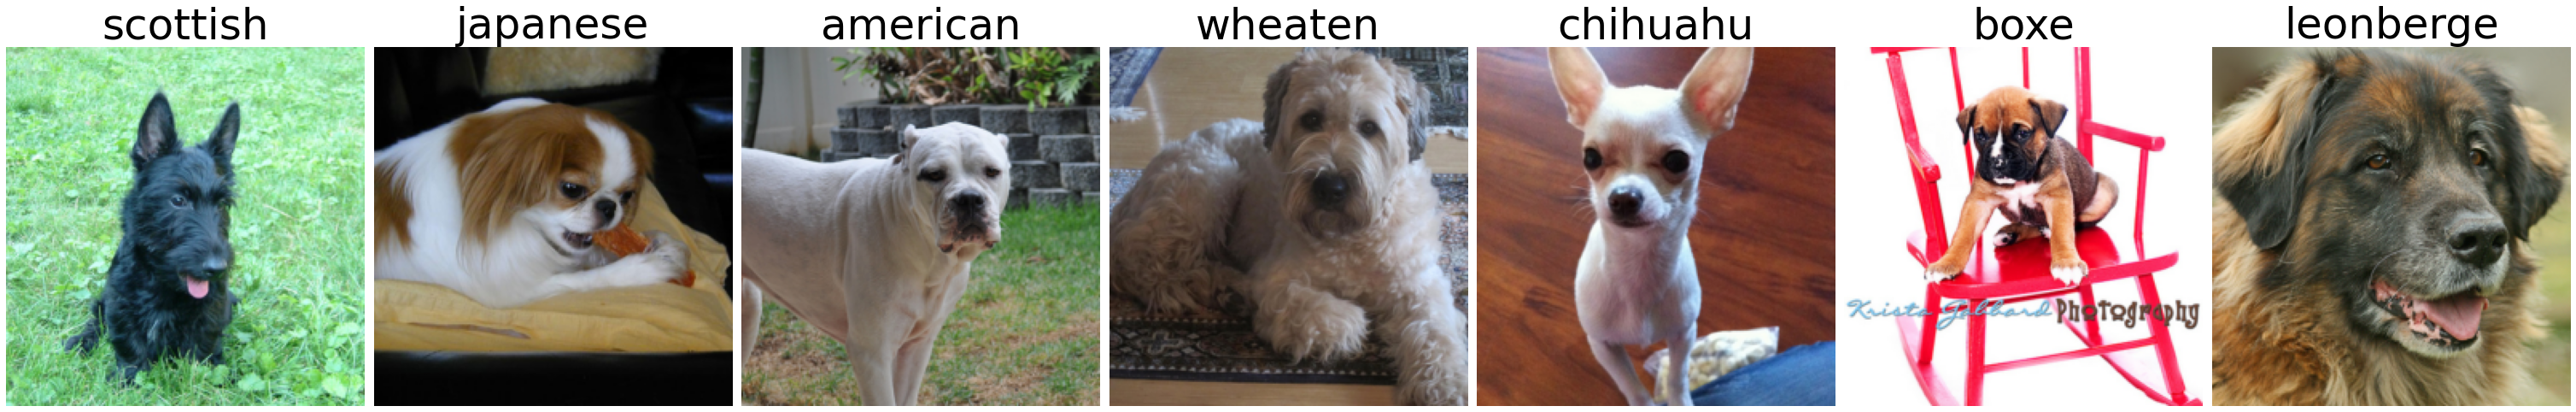

In [6]:
for _,(i,l) in zip(range(3),train_loader):
    display_images(i[:7].permute(0,2,3,1),titles=[dataset.classes[x] for x in l[:7]],fontsize=50)

## Define a neural network

For image classification, you should probably define a convolutional neural network with several layers. What to keep an eye for:
* Keep in mind the pyramid architecture, i.e. number of filters should increase as you go deeper
* Do not forget activation functions between layers (ReLU) and Max Pooling
* Final classifier can be with or without hidden layers, but the number of output neurons should be equal to number of classes.

An important thing is to get the activation function on the last layer + loss function right:
* In Tensorflow, you can use `softmax` as the activation, and `sparse_categorical_crossentropy` as loss. The difference between sparse categorical cross-entropy and non-sparse one is that the former expects output as the number of class, and not as one-hot vector.
* In PyTorch, you can have the final layer without activation function, and use `CrossEntropyLoss` loss function. This function applies softmax automatically. 

> **Hint:** In PyTorch, you can use `LazyLinear` layer instead of `Linear`, in order to avoid computing the number of inputs. It only requires one `n_out` parameter, which is number of neurons in the layer, and the dimension of input data is picked up automatically upon first `forward` pass.

In [11]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,32,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32,64,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.LazyLinear(2000),
    torch.nn.ReLU(),    
    torch.nn.LazyLinear(num_classes)
)

## Train the Neural Network

Now we are ready to train the neural network. During training, please collect accuracy on train and test data on each epoch, and then plot the accuracy to see if there is overfitting.

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

In [13]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = torch.nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        f = features.to(device)
        l = labels.to(device)
        optimizer.zero_grad()
        out = net(f)
        loss = loss_fn(out,l) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==l).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=torch.nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            f = features.to(device)
            l = labels.to(device)
            out = net(f)
            loss += loss_fn(out,l) 
            pred = torch.max(out,1)[1]
            acc += (pred==l).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=torch.nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

hist = train(model,train_loader,test_loader,epochs=10,lr=0.001,loss_fn=torch.nn.CrossEntropyLoss())

Epoch  0, Train acc=0.060, Val acc=0.084, Train loss=0.055, Val loss=0.054
Epoch  1, Train acc=0.129, Val acc=0.118, Train loss=0.050, Val loss=0.052
Epoch  2, Train acc=0.226, Val acc=0.156, Train loss=0.044, Val loss=0.051
Epoch  3, Train acc=0.409, Val acc=0.154, Train loss=0.033, Val loss=0.056
Epoch  4, Train acc=0.695, Val acc=0.147, Train loss=0.017, Val loss=0.072
Epoch  5, Train acc=0.923, Val acc=0.144, Train loss=0.005, Val loss=0.094
Epoch  6, Train acc=0.981, Val acc=0.164, Train loss=0.001, Val loss=0.105
Epoch  7, Train acc=0.992, Val acc=0.145, Train loss=0.001, Val loss=0.126
Epoch  8, Train acc=0.991, Val acc=0.145, Train loss=0.001, Val loss=0.118
Epoch  9, Train acc=0.994, Val acc=0.144, Train loss=0.000, Val loss=0.132


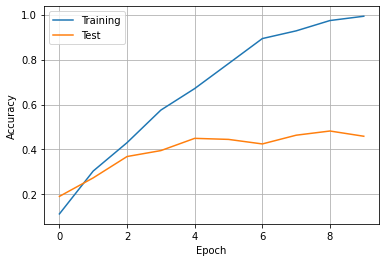

In [12]:
plt.plot(hist['train_acc'],label='Training')
plt.plot(hist['val_acc'],label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looks like the accuracy is far from great!

## Transfer Learning

To improve the accuracy, let's use pre-trained neural network as feature extractor. Feel free to experiment with VGG-16/VGG-19 models, ResNet50, etc.

> Since this training is slower, you may start with training the model for the small number of epochs, eg. 3. You can alsways resume training to further improve accuracy if needed.

We need to normalize our data differently for transfer learning, thus we will reload the dataset again using different set of transforms:

In [46]:
std_normalize = tr.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = tr.Compose([
        tr.Resize(256),
        tr.CenterCrop(224),
        tr.ToTensor(), 
        std_normalize])

dataset = torchvision.datasets.ImageFolder('images',transform=trans)

n = len(dataset)
n_train = int(0.8*n)
train_data,test_data = torch.utils.data.random_split(dataset,[n_train,n-n_train])

train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)

Let's load the pre-trained network:

In [51]:
vgg = torchvision.models.vgg16(pretrained=True)
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

There is a slot called `classifier`, which you can replace with your own classifier for the desired number of classes. We will also move the model to GPU device:

In [52]:
vgg.classifier = torch.nn.LazyLinear(num_classes)

Make sure to set all parameters of VGG feature extractor not to be trainable using `requires_grad` property:

In [53]:
for x in vgg.features.parameters():
    x.requires_grad = False
vgg = vgg.to(device)

Now we can start the training. Be very patient, as training takes a long time, and our train function is not designed to print anything before the end of the epoch.

In [54]:
hist = train(vgg,train_loader,test_loader,epochs=3,lr=0.001,loss_fn=torch.nn.CrossEntropyLoss())

Epoch  0, Train acc=0.709, Val acc=0.809, Train loss=0.028, Val loss=0.020
Epoch  1, Train acc=0.952, Val acc=0.848, Train loss=0.003, Val loss=0.016
Epoch  2, Train acc=0.978, Val acc=0.851, Train loss=0.001, Val loss=0.018


It seems much better now!

## Optional: Calculate Top3 Accuracy

We can also computer Top3 accuracy using the same code as in the previous exercise.


In [55]:
correct = 0
total = 0
for t,l in test_loader:
    out = vgg(t.to(device))
    _,r = out.topk(5,1,True,True)
    r = r.t()
    correct += r.eq(l.to(device).view(1,-1).expand_as(r)).sum()
    total += len(l)
print(correct/total)

tensor(0.9878, device='cuda:0')
